# **Visão Computacional Aplicada na Detecção de Equipamentos de Proteção Individual**

Este notebook realiza a detecção de EPIs (Equipamentos de Proteção Individual) em tempo real através da webcam. 

## 🚨 **ATENÇÃO!!!** Leia antes de executar os códigos:
  - Recomenda-se utilizar navegador Google Chrome.
  - No canto superior esquedo da tela vá em Editar -> Configurações de Notebook -> Acelerador de Hardware e certifique-se que GPU esteja selecionado. Salve!
  - No canto superior direito clique em conectar.
  - Você pode executar cada célula de cada vez ou ir em  Ambiente de execução -> Executar tudo.
  - A configuração do ambiente deve levar cerca de 3 minutos. O programa irá realizar dois testes em duas imagens. Então seu navegador irá pedir acesso a sua câmera. Permita.
  - Vá até o final da página para vizualizar sua câmera.
  - Para que a câmera para de gravar clique sobre a imagem!

# **Configuração do Ambiente**

In [1]:
# Importação de bibliotecas
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Instalar Git LFS para trabalhar com arquivos grandes
!curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | sudo bash
!sudo apt-get install git-lfs
!git lfs install

Detected operating system as Ubuntu/bionic.
Checking for curl...
Detected curl...
Checking for gpg...
Detected gpg...
Running apt-get update... done.
Installing apt-transport-https... done.
Installing /etc/apt/sources.list.d/github_git-lfs.list...done.
Importing packagecloud gpg key... done.
Running apt-get update... done.

The repository is setup! You can now install packages.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following packages will be upgraded:
  git-lfs
1 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
Need to get 7,168 kB of archives.
After this operation, 7,962 kB of additional disk space will be used.
Get:1 https://packagecloud.io/github/git-lfs/ubuntu bionic/main amd64 git-lfs amd64 3.2.0 [7,168 kB]
Fetched 7,168 kB in 1s (7,517 kB/s)
debconf: unable to initiali

In [3]:
# Clonar repositório darknet
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15490, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 15490 (delta 10), reused 21 (delta 9), pack-reused 15460
Receiving objects: 100% (15490/15490), 14.10 MiB | 11.57 MiB/s, done.
Resolving deltas: 100% (10397/10397), done.


In [4]:
# Habilitar GPU, OPENCV e LIBSO
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

/content/darknet


In [5]:
# criar darknet
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -fPIC -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old ==

In [6]:
# Clonar o repositório Visão Computacional Aplicada na Detecção de Equipamentos de Proteção Individual (EPIs)
!git clone https://github.com/felipeSperb/VCAD_EPIs

Cloning into 'VCAD_EPIs'...
remote: Enumerating objects: 108, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 108 (delta 9), reused 0 (delta 0), pack-reused 80
Receiving objects: 100% (108/108), 2.82 MiB | 2.12 MiB/s, done.
Resolving deltas: 100% (15/15), done.


# **Declaração de Funções**

In [7]:
# importar funções darknet para detecção de objetos
from darknet import *
# load in our YOLOv4 architecture network
network, class_names, class_colors = load_network("VCAD_EPIs/YOLOv4/yolov4-epi.cfg", "VCAD_EPIs/YOLOv4/epi.data", "VCAD_EPIs/YOLOv4/yolov4-epi360_3200.weights")
width = network_width(network)
height = network_height(network)

# função auxiliar darknet para executar detecção na imagem
def darknet_helper(img, width, height):
  darknet_image = make_image(width, height, 3)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR)

  # obter relações de imagem para converter caixas delimitadoras para o tamanho adequado
  img_height, img_width, _ = img.shape
  width_ratio = img_width/width
  height_ratio = img_height/height

  # execute o modelo em uma imagem estilo darknet para obter detecções
  copy_image_from_bytes(darknet_image, img_resized.tobytes())
  detections = detect_image(network, class_names, darknet_image)
  free_image(darknet_image)
  return detections, width_ratio, height_ratio

In [8]:
# função para mostrar um arquivo
def imShow(path):
  # import cv2
  # import matplotlib.pyplot as plt
  # %matplotlib inline

  img = cv2.imread(path)
  altura, largura = img.shape[:2]
  redimensionarImg = cv2.resize(img,(3*largura, 3*altura), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(redimensionarImg, cv2.COLOR_BGR2RGB))
  plt.show()

In [9]:
# função para converter o objeto JavaScript em uma imagem OpenCV
# isso é necessário porque o ambiente do Google Colab não suporta algumas funções nativas OpenCV
def js_to_image(js_reply):
  """
  Params:
          js_reply: Objeto JavaScript contendo imagem da webcam
  Returns:
          img: OpenCV BGR imagem
  """
  # decodificar imagem base64
  image_bytes = b64decode(js_reply.split(',')[1])
  # converter bytes em array numpy
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decodificar array numpy em imagem OpenCV BGR
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# função para converter a imagem da caixa delimitadora do retângulo OpenCV em string de bytes de base64 a ser sobreposta no fluxo de vídeo
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) contendo retângulo para sobrepor no fluxo de vídeo.
  Returns:
        bytes: String de byte de imagem Base64
  """
  # converter matriz em imagem PIL
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # formatar bbox em png
  bbox_PIL.save(iobuf, format='png')
  # formatar string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [10]:
# Função JavaScript para criar transmissão de vídeo usando webcam
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'Click na imagem para parar o processo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

# **Teste da rede neural em uma imagem**

Aqui você pode vizualizar as camadas convolucionais e as detecções dos EPIs em uma imagem.
Para testar com outra imagem, nomei está imagem com o nome **teste1.jpg** e arraste está imagem para a pasta GoogleColabVersion (caminho: /content/darknet/VCAD_EPIs/GoogleColabVersion/teste1.jpg) 
Obs.: Caso sua imagem não seja .jpg apenas altere a extenção no final da linha de código abaixo.

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   3 route  1 		                           ->  208 x 208 x  64 
   4 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   5 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   6 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   8 conv  

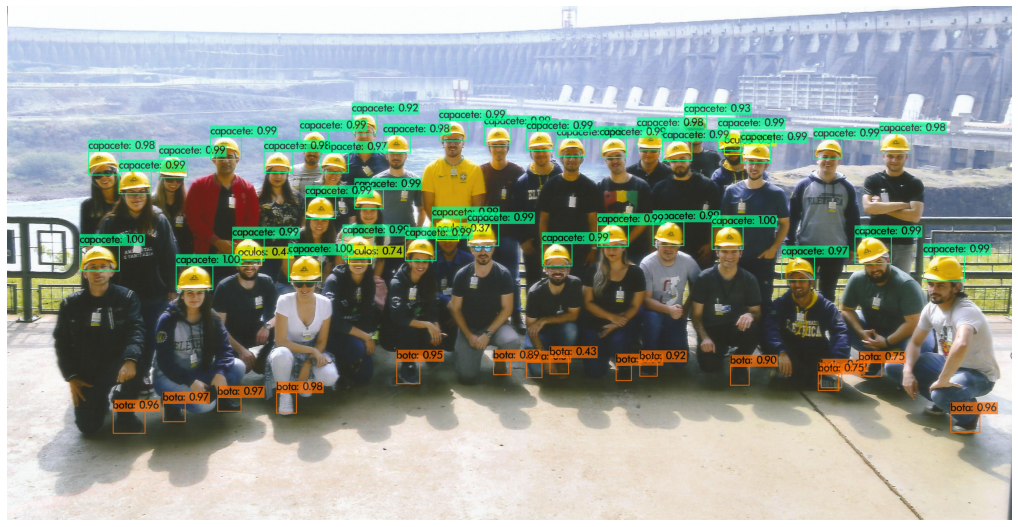

In [11]:
!./darknet detector test VCAD_EPIs/YOLOv4/epi.data VCAD_EPIs/YOLOv4/yolov4-epi.cfg VCAD_EPIs/YOLOv4/yolov4-epi360_3200.weights VCAD_EPIs/GoogleColabVersion/teste1.jpg -thresh 0.3
imShow('predictions.jpg')

# **Teste do código que será usado em tempo real em uma imagem**

Para testar com outra imagem, nomei está imagem com o nome **teste2.png** e arraste está imagem para a pasta GoogleColabVersion (caminho: /content/darknet/VCAD_EPIs/GoogleColabVersion/teste2.png).
Obs.: Caso sua imagem não seja .png apenas altere a extenção no final da linha de código abaixo.

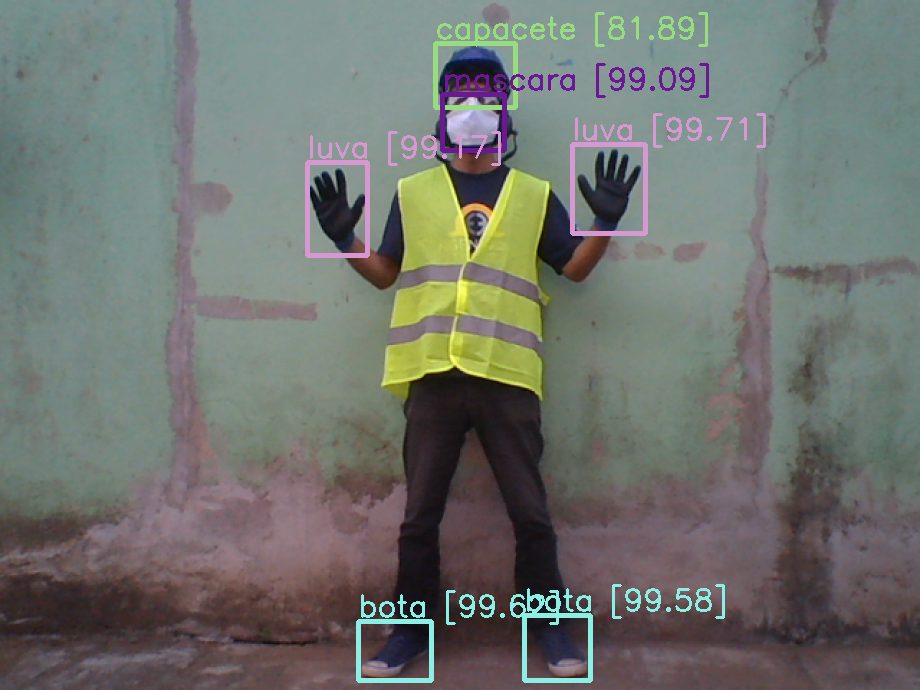

In [12]:
# Teste em Imagem
image = cv2.imread("VCAD_EPIs/GoogleColabVersion/imgTeste.png")
detections, width_ratio, height_ratio = darknet_helper(image, width, height)

for label, confidence, bbox in detections:
  left, top, right, bottom = bbox2points(bbox)
  left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
  cv2.rectangle(image, (left, top), (right, bottom), class_colors[label], 4)
  cv2.putText(image, "{} [{:.2f}]".format(label, float(confidence)),
                    (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 1,
                    class_colors[label], 2)
cv2_imshow(image)

# **Detecção dos EPIs em tempo real através da webcam 📸**

Para parar a tranmissão, clique sob a imagem.

In [14]:
# começar a transmitir vídeo da webcam
video_stream()
# label for video
label_html = 'Capturing...'
# inicializar a caixa delimitadora
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # converter resposta JS para imagem OpenCV
    frame = js_to_image(js_reply["img"])

    # criar sobreposição transparente para a caixa delimitadora
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # chamar função darknet helper
    detections, width_ratio, height_ratio = darknet_helper(frame, width, height)

    # fazar um loop pelas detecções e desenhar na imagem de sobreposição transparente
    for label, confidence, bbox in detections:
      left, top, right, bottom = bbox2points(bbox)
      left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
      bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), class_colors[label], 1)
      bbox_array = cv2.putText(bbox_array, "{} [{:.2f}]".format(label, float(confidence)),
                        (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        class_colors[label], 1)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # converter a sobreposição de bbox em bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # atualiza o bbox para que o próximo quadro receba uma nova sobreposição
    bbox = bbox_bytes

<IPython.core.display.Javascript object>